# Importing Necessary Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
import cv2
import numpy

# Load the data
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

# Display the first 10 faces
fig, ax = plt.subplots(2, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
            
# Compute the mean face
mean = faces.data.mean(axis=0)
fig, ax = plt.subplots(1, 1)

ax.imshow(mean.reshape(faces.images[0].shape), cmap='bone')
ax.set(xticks=[], yticks=[], xlabel='Mean Face')

# Compute the eigenfaces
from sklearn.decomposition import PCA
pca = PCA(150).fit(faces.data)
eigenfaces = pca.components_.reshape((150, 62, 47))



# Loading Dataset (preprocessing + train-test split)

__We are taking the image of only those classes which have atleast 70 image and resizing the image__

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70,resize=0.4)
n_samples, h, w = lfw_people.images.shape

__X          : is the Matrix of Images with images being in column__
<br>
__n_features : is no of images in Dataset__
<br>
__y          : contains the label of each Image__
<br>
__n_classes  : represents No of distinct images__ 

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


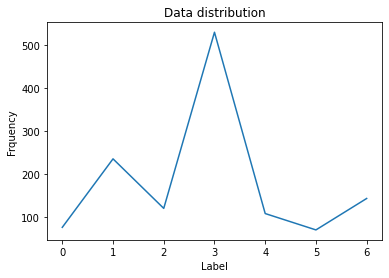

In [ ]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)

X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
unique, counts = numpy.unique(y, return_counts=True)

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

plt.plot(unique, counts)
plt.xlabel('Label')
plt.ylabel('Frquency')
plt.title('Data distribution')
plt.show()

__Spliting the Dataset in test and train with percentage of test dataset being 30%__

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(966, 1850)
(322, 1850)
(966,)
(322,)


# Calculating Average Face

__Calculating the Average Face from the Training Images and Centering the Train and Test Image Matrix__

In [ ]:
avgFace =  np.mean(X_train,axis=0)
X_train_centred = X_train - avgFace
X_test_centred = X_test - avgFace
print(X_train.shape)# we have 966 sample In train
print(X_test.shape)# we have 322 smaple in Test

(966, 1850)
(322, 1850)


# Inbuilt PCA

__This is code is using the standard PCA from sklearn For Comparision purpose with our implementation of PCA__

In [ ]:
from sklearn.decomposition import PCA
n_components = 150
pca = PCA(n_components=n_components,whiten='True',svd_solver="randomized").fit(X_train_centred)
pcaEigenvector = pca.components_
X_train_pca = pca.transform(X_train_centred)
X_test_pca = pca.transform(X_test_centred)

####################################
# Prediction 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_pca,y_train)
correct=0
incorrect=0
predictedLabel = neigh.predict(X_test_pca)
for i in range(len(y_test)):
    if(y_test[i] ==predictedLabel[i]):
        correct=correct+1
    else:
        incorrect=incorrect+1
print("Accuracy : ",correct/(incorrect+correct))

Accuracy :  0.6956521739130435


__With the Standard Implementation we are able to get an Accuracy of 70.47%__

# PCA Implementation From scratch

 1. __Calculating Covariance Matrix of $X.X^{T}$__

In [ ]:
coVariance_Matrix =np.matmul(X_train_centred,X_train_centred.T)

In [ ]:
print(coVariance_Matrix.shape)

(966, 966)


2. __Calculating the Eigen Value and Eigen Vector of $X.X^{T}$__

In [ ]:
#Calculating Eigen Vector and Value
w , v = np.linalg.eig(coVariance_Matrix)# W is eigenVector and V is Matrix of EigenVector ColoumnWise

we got 966 Eigen Value and Eigen Vector

In [ ]:
print(v[0,:].shape)

(966,)


__This is the Plot showing the first 20 eigen values__

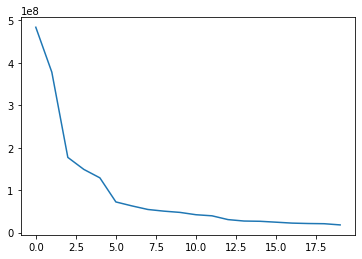

In [ ]:
plt.plot(w[:20])
plt.show()

3. __Sorting the Eigen Vectors based on their Eigen Values in decreasing Order__ 

In [ ]:
eigenVal_eigenVec = list()
for i in range(X_train.shape[0]):
    eigenVal_eigenVec.append([w[i] , v[:,i]])
sortedeeV =sorted(eigenVal_eigenVec, key=lambda x: x[0],reverse=True)

4. __Converting the Eigen Vectors from Face space to Original space__ 

In [ ]:
#Converting eigenvector from 966 x1  to  2914x 1
#Square root 
eigenVectors = list()
for i in sortedeeV:
    eigenVector = np.matmul(X_train.T,i[1])/i[0]
    #unitEigenVector = eigenVector/(np.linalg.norm(eigenVector))
    eigenVectors.append(eigenVector)
eigenVectors = np.asarray(eigenVectors)
print(eigenVectors.shape)

(966, 1850)


__The eigenRepresentation function takes a image and project it to the face space by taking the dot product of the image with the top N eigen Vectors__

In [ ]:
def eigenRepresentation(img,eigenVectors,dim):
    imgReresentation = np.zeros((dim))
    for i in range(dim):
        imgReresentation[i] = np.dot(img,eigenVectors[i])/np.linalg.norm(img)
    return imgReresentation

In [ ]:
n_dim_pca = 150
X_train_pca = list()# Projecting the training set
for sample in X_train_centred:
    X_train_pca.append(eigenRepresentation(sample,eigenVectors,n_dim_pca))
X_test_pca = list()# Projecting the testing set
for sample in X_test_centred:
    X_test_pca.append(eigenRepresentation(sample,eigenVectors,n_dim_pca))
avgProjectedFace = np.mean(X_train_pca,axis=0)

# Implementation of LDA

**Importing all the libraries required for LDA**

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")

num_classes = n_classes

## Helper functions

In [ ]:
# compute the mean matrix for each of the 7 classes
def compute_classes_mean_matrix(train_data,train_labels, num_classes):
    '''
    This function computes mean for each class. The output dimension
    will be Cxm (C-number of classes; m-number of features)
    Input:
      @param train_data: features of training samples (X_train)
      @param train_labels: labels of training samples (y_train)
      @param num_classes: number of classes
    Output:
      return [list[list]]: list of class means
    '''
    means = np.zeros((num_classes, train_data.shape[1]))
    # train_test_split_ratio = 3
    for i in range(0,num_classes):
        temp = np.where(train_labels == i)[0]
        temp_sum = np.zeros((1,train_data.shape[1]))
        for j in temp:
           temp_sum += train_data[j,:]
        Ni = len(temp)
        means[i,:] = temp_sum / Ni
    return means

In [ ]:
def compute_overall_mean(train_data):
  '''
  This function computes overall mean of training dataset
  (average image for all classes in the training dataset).
  The output dimension will be 1x1
  Input:
    @param train_data: features of training samples (X_train)
  Output:
    return overall_mean: overall mean of training samples
  '''
  temp_sum = np.zeros((1,train_data.shape[1]))
  for i in range(train_data.shape[0]):
    temp_sum += train_data[i,:]
  overall_mean = temp_sum/train_data.shape[0]
  return overall_mean

In [ ]:
#the overall mean for all the 7 classes
# def compute_overall_mean_matrix(classes_means, num_classes):
#     temp_sum = np.zeros((1,classes_means.shape[1]))
#     for i in range(0,num_classes):
#         temp_sum += classes_means[i,:]
#     overall_mean = temp_sum / num_classes
    
#     return overall_mean.T

In [ ]:
#the matrix of the overall scatter between all the classes
def compute_between_class_scatter_matrix(train_labels, classes_means,overall_mean):
    '''
    This function will compute scatter matrix between all the
    classes available with the image dataset its computed on 
    variance of each class by using overall means
    '''
    Sb = np.zeros((classes_means.shape[1],classes_means.shape[1]))
    for i in range(classes_means.shape[0]):
        Ni = len(np.where(train_labels==i)[0])
        Sb = np.add(Sb,Ni* ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))
    return Sb

In [ ]:
def compute_center_class_matrix(train_data,train_labels,classes_means):
    '''
    Here we will compute center clas scatter for each and every data or image 
    for which we will do subtract class mean of each class data to obtain center 
    class scatter matrix.
    '''
    Z = np.zeros(train_data.shape)
    for i in range(train_data.shape[0]):
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]

    return Z

In [ ]:
def compute_class_scatter_matrix(Z, shape_):
    '''
    this will give class scatter matrix on center class scatter 
    which we have computed for each data/image and we will do linear 
    transformation to get it.
    '''
    S = np.zeros((shape_,shape_))
    S = np.dot(Z.T,Z)
    print("The shape of scatter matrix",S.shape)
    return S 

In [ ]:
# classes_means = compute_classes_mean_matrix(X_train,y_train, num_classes)
X_train_pca = np.array(X_train_pca)
X_test_pca = np.array(X_test_pca)
classes_means = compute_classes_mean_matrix(X_train_pca,y_train, num_classes)
print("Class Means: ", classes_means.shape)
overall_mean = compute_overall_mean(X_train_pca)
print("Overall Mean: ", overall_mean.shape)
S_between = compute_between_class_scatter_matrix(y_train, classes_means,overall_mean)
print("Sb: ", S_between.shape)
Z = compute_center_class_matrix(X_train_pca, y_train, classes_means)
print("Z: ", Z.shape)

Class Means:  (7, 150)
Overall Mean:  (1, 150)
Sb:  (150, 150)
Z:  (966, 150)


In [ ]:
S_classes = compute_class_scatter_matrix(Z, X_train_pca.shape[1])
print("Sw: ", S_classes.shape)
W_value = np.dot(np.linalg.inv(S_classes),S_between)
print("W: ", W_value.shape)
print(np.min(W_value))
print(np.max(W_value))

The shape of scatter matrix (150, 150)
Sw:  (150, 150)
W:  (150, 150)
-0.14018565645583939
0.27472741811706375


In [ ]:
eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((X_train_pca.shape[1]-num_classes+1),(X_train_pca.shape[1]-1)))
print("Eigen Values: ", eigen_values.shape)
print("Eigen Vectors: ", eigen_vectors.shape)
# eigen_values = eigen_values[::-1]
print(eigen_values)

Eigen Values:  (6,)
Eigen Vectors:  (150, 6)
[0.14054276 0.18018782 0.20095206 0.33477082 0.83803453 1.02129971]


In [ ]:
def data_dimencionality_reduction(train_data,test_data, num_classes):
    '''
    this will be last step to get reduced dimension labelled data/images
    where we input train and test data along with number of classes to
    obtain finally reduced dimension data.
    '''
    train_data_dimensionally_reductuted = np.zeros((train_data.shape[0],num_classes)) 
    test_data_dimensionally_reductuted = np.zeros((test_data.shape[0],num_classes)) 
    
    i=0
    for img in train_data:
        train_data_dimensionally_reductuted[i,:]=np.dot(img,eigen_vectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reductuted[i,:] = np.dot(img,eigen_vectors)
        i+=1
        
    return train_data_dimensionally_reductuted,test_data_dimensionally_reductuted

In [ ]:
train_data_dimensionally_reductuted,test_data_dimensionally_reductuted = data_dimencionality_reduction(X_train_pca,X_test_pca, num_classes-1)

In [ ]:
def plot_accuracy_graph(accuracy, k_list):
    '''
    this will plot the graph for accuracy of target image 
    classified correctly or not
    '''
    plt.figure(figsize=(12, 6))
    plt.plot(k_list, accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    # plt.ylim(0, 70)
    plt.title('Accuracy for each K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy %')

## Compute LDA

In [ ]:
classes_means = compute_classes_mean_matrix(X_train,y_train, num_classes)
print('Done classes means computing')
print('-----------------------------------------------------------')

In [ ]:
overall_mean = compute_overall_mean_matrix(classes_means, num_classes)
print('Done overall mean computing')
print('-----------------------------------------------------------')

In [ ]:
S_between = compute_between_class_scatter_matrix(classes_means,overall_mean, num_classes)
print('Done between class scater matrix computing')
print('-----------------------------------------------------------')

In [ ]:
Z = compute_center_class_matrix(X_train,y_train,classes_means)
print('Done center class scatter matrix computing')
print('-----------------------------------------------------------')

In [ ]:
S_classes = compute_class_scatter_matrix(Z, X_train.shape[1])
print('Done within class scatter matrix computing')
print('-----------------------------------------------------------')

In [ ]:
W_value = np.dot(np.linalg.inv(S_classes),S_between)
print('Done W = Sw^(-1)*Sb  computing')
print('-----------------------------------------------------------')
print(W_value.shape)

In [ ]:
#7 largest eigen values
eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((X_train.shape[1]-num_classes),(X_train.shape[1]-1)))
print('Done eigen values and vectors computing')
print('-----------------------------------------------------------')
print(eigen_values)

In [ ]:
#reduce dimensionality of both train and test data sets
train_data_dimensionally_reductuted,test_data_dimensionally_reductuted = data_dimencionality_reduction(X_train,X_test, num_classes)

## Apply KNN

Accuracy Max:  84.472049689441  Index:  8


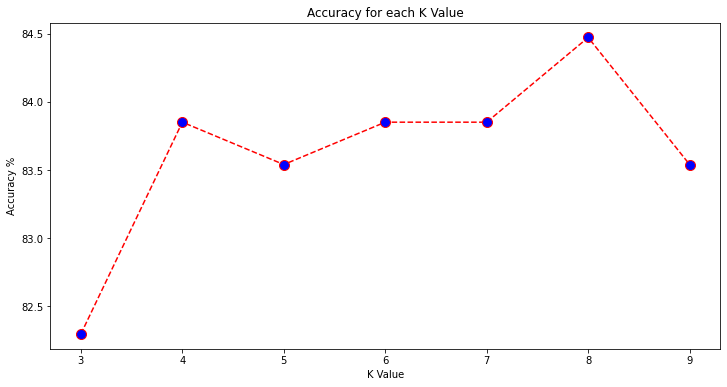

In [ ]:
accuracy = []
max = -1
index = -1
#Apply KNN
k_list = [i for i in range(3, 10)]
for i in k_list:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_data_dimensionally_reductuted, y_train)

    test_predict = classifier.predict(test_data_dimensionally_reductuted)
    
    true_predicted_count=0
    for j in range(0,len(test_predict)):
        if test_predict[j] ==y_test[j]:
            true_predicted_count+=1
    accuracy.append((true_predicted_count/len(test_predict))*100)
    if max<(true_predicted_count/len(test_predict))*100:
      max = (true_predicted_count/len(test_predict))*100
      index = i

#plot graph for different K values
plot_accuracy_graph(accuracy, k_list)
print("Accuracy Max: ",max," Index: ",index)

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(X_train_pca, y_train)

predictions = clf.predict(X_test_pca)
correct = 0
for i in range(y_test.shape[0]):
  if predictions[i]==y_test[i]:
    correct += 1

print("Accuracy: ", (correct/len(predictions)))

Accuracy:  0.8571428571428571


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_train_pca)

Text(0.5, 1.0, 'T-SNE plot for first 5000 training samples')

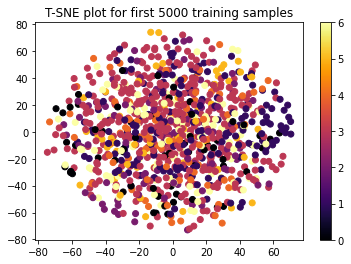

In [ ]:
X_embedded = TSNE(n_components=3,learning_rate='auto',init='random').fit_transform(pca_result)
plt.scatter(x=X_embedded[:,0],y=X_embedded[:,1],c=y_train,cmap='inferno')#'inferno')
plt.colorbar()
plt.title("T-SNE plot for first 5000 training samples")

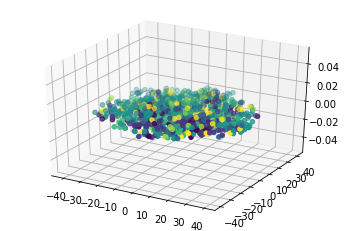

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], zs=0, zdir='z', s=20, c=y_train, depthshade=True)